<a href="https://colab.research.google.com/github/KaosElegent/tensorflow-fun/blob/main/tfTextClassification(Wines).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install pyyaml h5py  # Required to save models in HDF5 format


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub # a bunch of trained machine learning models

In [26]:
from tensorflow import keras

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
# we notice that there are NaNs so lets remove NaNs from desc and points (we dont care abt price)
df = df.dropna(subset=['description','points'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


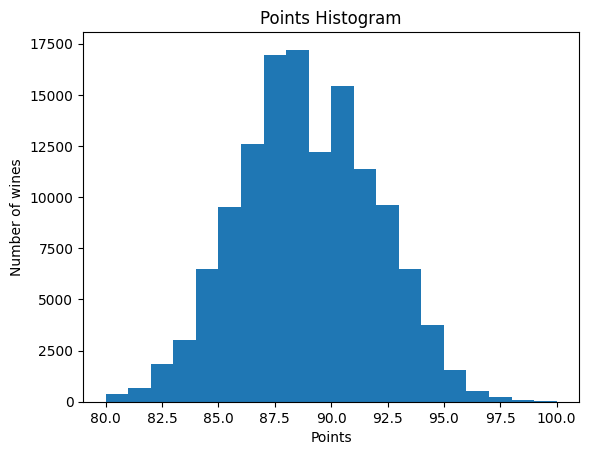

In [6]:
# now lets just study the data a little nd see what the point ditribution looks like with a histogram
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("Number of wines")
plt.xlabel("Points")
plt.show()

It seems that a lot of the wines are split at the 90 points mark, so let's classify wines as >90 and <90.


In [7]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'points', 'label']]
df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [8]:
# Now lets split this into training, validation and test data sets

# frac=1 samples all the data randomly
# one cut at the 80% mark and one cut at the 90% mark
# ie. 80% for train, 10% for val, 10% for test
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)) , int(0.9*len(df))])

In [9]:
# https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)  # think of this as something for optimization / speeding things up
  return ds


In [10]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [11]:
embedding = hub.load("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim50/versions/1")
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [12]:
hub_layer(list(train_data)[0][0]) # this is a showcase to show that the embedding just converts all the text in our dataset into
# a vector of numbers that our model can understand

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.7077397 , -0.12939146, -0.3143256 , ..., -0.03836589,
        -0.23671854, -0.09750315],
       [ 0.28826162,  0.2639197 ,  0.20428152, ..., -0.10390925,
        -0.21604303,  0.05308627],
       [ 0.5634246 , -0.19304463, -0.03979643, ..., -0.02123478,
        -0.27969798,  0.00769919],
       ...,
       [ 0.13755055, -0.24119848,  0.01717466, ...,  0.14510357,
        -0.01829079,  0.14597172],
       [ 0.29300553, -0.21517599,  0.00542397, ..., -0.13178036,
        -0.10225157,  0.27486044],
       [ 0.19717015, -0.2436294 ,  0.14658704, ...,  0.03091245,
         0.1268981 , -0.0048413 ]], dtype=float32)>

In [13]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) # This is added because otherwise the model is overfed training data and it
# becomes worse at generalising, which means we needs to add some obstacles/randomness in the NN.
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])


Evaluating the untrained model on data

In [15]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.7018 - accuracy: 0.4161


[0.7017855048179626, 0.4161345064640045]

In [16]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.7019 - accuracy: 0.4110


[0.7019044160842896, 0.41101792454719543]

In [17]:
# Training the model
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 148s 1s/step - loss: 0.6297 - accuracy: 0.6323 - val_loss: 0.5184 - val_accuracy: 0.7693
Epoch 2/5
102/102 [==============================] - 152s 1s/step - loss: 0.4754 - accuracy: 0.7727 - val_loss: 0.4029 - val_accuracy: 0.8202
Epoch 3/5
102/102 [==============================] - 136s 1s/step - loss: 0.3983 - accuracy: 0.8267 - val_loss: 0.3809 - val_accuracy: 0.8292
Epoch 4/5
102/102 [==============================] - 136s 1s/step - loss: 0.3635 - accuracy: 0.8462 - val_loss: 0.3745 - val_accuracy: 0.8291
Epoch 5/5
102/102 [==============================] - 135s 1s/step - loss: 0.3389 - accuracy: 0.8590 - val_loss: 0.3753 - val_accuracy: 0.8316


In [18]:
model.evaluate(test_data)

13/13 [==============================] - 6s 353ms/step - loss: 0.3702 - accuracy: 0.8349


[0.37020987272262573, 0.8348976969718933]

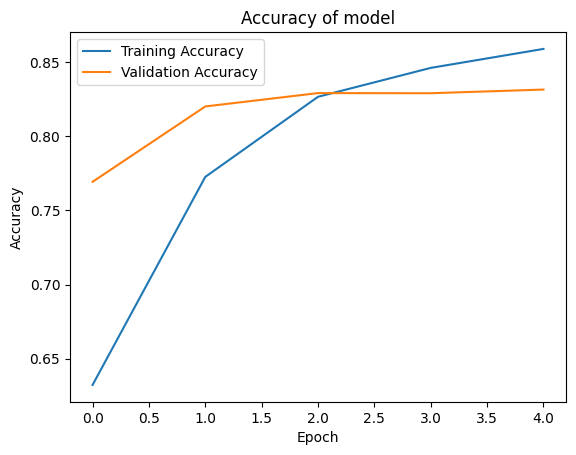

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191705 (183.84 MB)
Trainable params: 481

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [30]:
model.summary()
model.save("/content/wine-reviews")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191705 (183.84 MB)
Trainable params: 481

We used the tensorflow hub here for the encoding, so here's hw to do it using a LSTM

In [33]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [34]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that', 'finish', 'acidity', 'from', 'but', 'tannins',
       'drink', 'cherry', 'ripe', 'are', 'black', 'has', 'for', 'by',
       'notes', 'red', 'spice', 'as', 'an', 'rich', 'fresh', 'nose',
       'oak', 'berry', 'dry', 'now', 'plum', 'soft', 'fruits', 'blend',
       'apple'], dtype='<U17')

In [37]:
#size of our LSTM is 32 and it is masked to handel variabel sequence length
# the first two parameters convert the text into a vector of numaricals that our neural net can read
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])


In [39]:
model.evaluate(train_data)

102/102 [==============================] - 24s 154ms/step - loss: 0.6931 - accuracy: 0.5159


[0.6930859684944153, 0.5158690214157104]

In [40]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 50s 419ms/step - loss: 0.5459 - accuracy: 0.7102 - val_loss: 0.3819 - val_accuracy: 0.8303
Epoch 2/5
102/102 [==============================] - 46s 444ms/step - loss: 0.3734 - accuracy: 0.8355 - val_loss: 0.3571 - val_accuracy: 0.8393
Epoch 3/5
102/102 [==============================] - 40s 386ms/step - loss: 0.3565 - accuracy: 0.8422 - val_loss: 0.3544 - val_accuracy: 0.8431
Epoch 4/5
102/102 [==============================] - 45s 439ms/step - loss: 0.3461 - accuracy: 0.8472 - val_loss: 0.3532 - val_accuracy: 0.8414
Epoch 5/5
102/102 [==============================] - 39s 384ms/step - loss: 0.3409 - accuracy: 0.8484 - val_loss: 0.3623 - val_accuracy: 0.8336


In [41]:
model.evaluate(test_data)

13/13 [==============================] - 2s 136ms/step - loss: 0.3571 - accuracy: 0.8326


[0.3570564091205597, 0.8325896263122559]